# MSIN0114 - Dissertation
# Notebook 2 - Feature Engineering

# Import Necessary Library

In [1]:
!pip install -U scikit-learn
!pip install pandarallel

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

import pandas as pd
import numpy as np
from functools import reduce
import glob
import time
import datetime

from itertools import tee, islice, chain

#Data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.ticker as ticker
from matplotlib import colors
from matplotlib.colors import ListedColormap
from matplotlib.ticker import FixedLocator, FixedFormatter

from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set(rc={"figure.figsize":(11.7,8.27)})

import plotly.express as px
import plotly.io as pio
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


         .:::.     .::.       
        ....yy:    .yy.       
        :.  .yy.    y.        
             :y:   .:         
             .yy  .:          
              yy..:           
              :y:.            
              .y.             
             .:.              
        ....:.                
        :::.                  

• Project files and data should be stored in /project. This is shared among everyone
  in the project.
• Personal files and configuration should be stored in /home/faculty.
• Files outside /project and /home/faculty will be lost when this server is terminated.
• Create custom environments to setup your servers reproducibly.

  Using cached scikit_learn-1.1.1-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (31.2 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1

         .:::.     .::.       
        ....yy:   

In [2]:
import requests

def telegram_bot_sendtext(bot_message):

    bot_token = '5544013184:AAEFue_7v4qLcmHEdS2uHBWU2hpQAczrZmU'
    bot_chatID = '1452370484'
    send_text = 'https://api.telegram.org/bot' + bot_token + '/sendMessage?chat_id=' + bot_chatID + '&parse_mode=Markdown&text=' + bot_message

    response = requests.get(send_text)

    return response.json()

# Import Data from Notebook 1

In [3]:
final_data_so = pd.read_csv('final_data_so.csv', 
                      lineterminator='\n',
                      delimiter=',',
                      parse_dates=['Order_Tstamp'])

/opt/anaconda/envs/Python3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.



In [4]:
data_so = final_data_so

In [5]:
data_so['Order_MY'] = data_so['Order_Tstamp'].dt.strftime('%Y-%m')

# Generate Target Variable & EDA

In [6]:
def get_target(data):
    data['next_order'] = data.groupby('Phone')['Order_Tstamp'].shift(periods=-1)
    data['days'] = (data['next_order'] - data['Order_Tstamp']).dt.days
    data['is_recurring'] = np.where(data['days'] < 30, 1, 0)
    data = data.drop(['next_order','days'],1)
    return data

In [7]:
def get_previous(data):
    data['prev_order'] = data.groupby('Phone')['Order_Tstamp'].shift(periods=1)
    data['prev_month'] = data['prev_order'].dt.month
    return data

In [8]:
def fsum(x, t, v):
    return x.apply(lambda y: x.loc[x['Order_Tstamp'].between(y['Order_Tstamp'] - t, 
                                                     y['Order_Tstamp'],
                                                     inclusive=False),v].sum(),axis=1)

def fcnt(x, t, v):
    return x.apply(lambda y: x.loc[x['Order_Tstamp'].between(y['Order_Tstamp'] - t, 
                                                     y['Order_Tstamp'],
                                                     inclusive=False),v].count(),axis=1)

def funi(x, t, v):
    return x.apply(lambda y: x.loc[x['Order_Tstamp'].between(y['Order_Tstamp'] - t, 
                                                     y['Order_Tstamp'],
                                                     inclusive=False),v].nunique(),axis=1)

In [9]:
start_time = time.time()
data_so = get_target(data_so)
data_so = get_previous(data_so)
print("--- %s seconds ---" % (time.time() - start_time))

--- 25.179532527923584 seconds ---


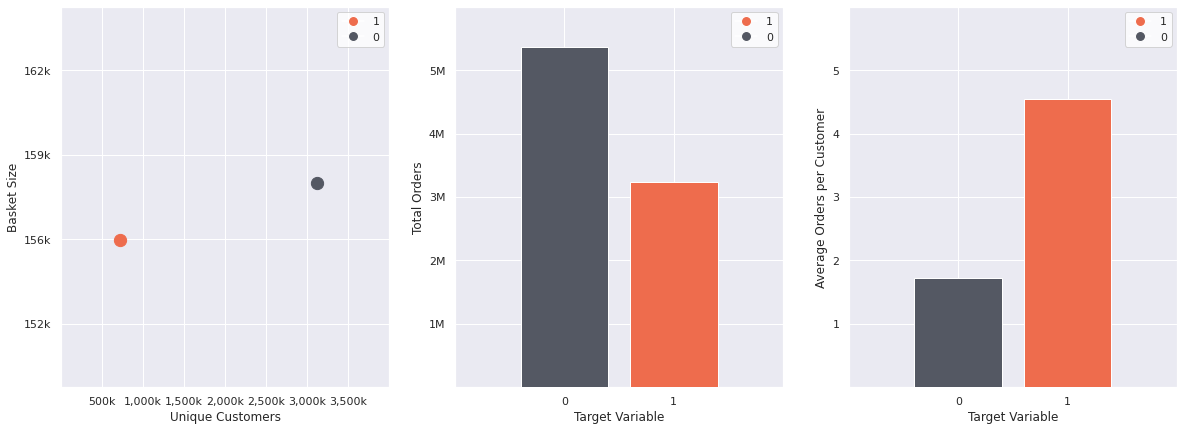

In [10]:
# Figure 12

# prepare data
temp = data_so.groupby('is_recurring').agg({'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'nunique'}).reset_index().rename(columns={'Order_Number':'count', 'Value_Taxed': 'sum', 'Phone': 'cust'})
temp['avg'] = temp['sum']/temp['count']
temp['avg_order'] = temp['count']/temp['cust']

# set up figures
fig, ax = plt.subplots(1,3,figsize = (20,7))

#plot data
# ax[0]
ax[0].scatter('cust', 'avg', color='#EE6C4D', s=150, data=temp[temp['is_recurring'] == 1], zorder=5)
ax[0].scatter('cust', 'avg', color='#545863', s=150, data=temp[temp['is_recurring'] == 0], zorder=5)

# set xtick labels
ax[0].set_xlim(xmin=0, xmax=4000000)
ax[0].set_xticks(pd.np.linspace(500000, 3500000,7))
xlabels = ['{:,.0f}'.format(x) + 'k' for x in ax[0].get_xticks()/1000]
ax[0].set_xticklabels(xlabels);

# set ytick labels
ax[0].set_ylim(ymin=150000, ymax=165000)
ax[0].set_yticks(pd.np.linspace(152500, 162500, 4))
ylabels = ['{:,.0f}'.format(x) + 'k' for x in ax[0].get_yticks()/1000]
ax[0].set_yticklabels(ylabels);

ax[0].set_xlabel('Unique Customers')
ax[0].set_ylabel('Basket Size')

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[0].legend(legend_elements, ['1', '0'], loc='upper right', facecolor='white')

#plot data
# ax[1]
ax[1].bar('is_recurring', 'count', color='#EE6C4D', data=temp[temp['is_recurring'] == 1], zorder=5)
ax[1].bar('is_recurring', 'count', color='#545863', data=temp[temp['is_recurring'] == 0], zorder=5)


# set xtick labels
ax[1].set_xlim(xmin=-1, xmax=2)
ax[1].set_xticks(pd.np.linspace(0, 1, 2))
xlabels = ['{:,.0f}'.format(x) for x in ax[1].get_xticks()]
ax[1].set_xticklabels(xlabels);

# set ytick labels
ax[1].set_ylim(ymin=0, ymax=6000000)
ax[1].set_yticks(pd.np.linspace(1000000, 5000000, 5))
ylabels = ['{:,.0f}'.format(x) + 'M' for x in ax[1].get_yticks()/1000000]
ax[1].set_yticklabels(ylabels);

ax[1].set_ylabel('Total Orders')
ax[1].set_xlabel('Target Variable')

from matplotlib.lines import Line2D
legend_elements = [Line2D([1], [1], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([1], [1], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[1].legend(legend_elements, ['1', '0'], loc='upper right', facecolor='white')

#plot data
# ax[2]
ax[2].bar('is_recurring', 'avg_order', color='#EE6C4D', data=temp[temp['is_recurring'] == 1], zorder=5)
ax[2].bar('is_recurring', 'avg_order', color='#545863', data=temp[temp['is_recurring'] == 0], zorder=5)


# set xtick labels
ax[2].set_xlim(xmin=-1, xmax=2)
ax[2].set_xticks(pd.np.linspace(0, 1, 2))
xlabels = ['{:,.0f}'.format(x) for x in ax[2].get_xticks()]
ax[2].set_xticklabels(xlabels);

# set ytick labels
ax[2].set_ylim(ymin=0, ymax=6)
ax[2].set_yticks(pd.np.linspace(1, 5, 5))
ylabels = ['{:,.0f}'.format(x) for x in ax[2].get_yticks()]
ax[2].set_yticklabels(ylabels);

ax[2].set_ylabel('Average Orders per Customer')
ax[2].set_xlabel('Target Variable')

from matplotlib.lines import Line2D
legend_elements = [Line2D([2], [2], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([2], [2], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax[2].legend(legend_elements, ['1', '0'], loc='upper right', facecolor='white')

plt.show()

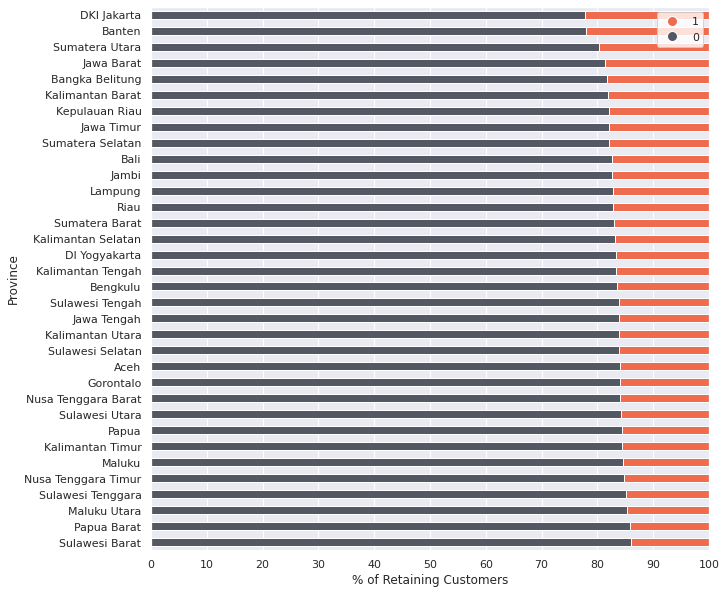

In [11]:
# Figure 13

# set up figures
fig, ax = plt.subplots(1,1,figsize = (10,10))

# plot data
perc_barh = data_so.groupby(['Province','is_recurring'])['Phone'].nunique().reset_index(name='cnt')
perc_barh['%'] = 100* perc_barh['cnt'] / perc_barh.groupby(['Province'])['cnt'].transform('sum')

perc_barh = perc_barh[perc_barh['Province']!='province_name_unclear']
perc_barh = perc_barh[['Province','is_recurring','%']]
perc_barh = perc_barh.pivot(index='Province', columns='is_recurring', values='%').reset_index().sort_values(by=1,ascending=True).fillna(0)

perc_barh.plot.barh(x='Province' , color=["#545863","#EE6C4D"], stacked=True, ax=ax)

# set ytick labels
ax.set_xlim(xmin=0, xmax=100)
ax.set_xticks(pd.np.linspace(0,100, 11))

ax.set_xlabel('% of Retaining Customers')
ax.set_ylabel('Province')

ax.get_legend().remove()

from matplotlib.lines import Line2D
legend_elements = [Line2D([2], [2], marker='o', color='w', label='Scatter',
                          markerfacecolor='#EE6C4D', markersize=10),
                   Line2D([2], [2], marker='o', color='w', label='Scatter',
                          markerfacecolor='#545863', markersize=10),]
ax.legend(legend_elements, ['1', '0'], loc='upper right', facecolor='white')

plt.show()

In [12]:
def get_var(data):
    
    '''
    ### GET VARIABLE ###
    This function generates variables for the final dataset.
    As the data is extensive (8 million rows), 
    we split the data and generate variables for each month separately. 
    Adjacent and subsequent months are combined as 
    features are generated from the last 30 days' historical data.
    As Pandas only uses a single-core CPU library, 
    Pandaralel library is used to benefit from a multi-core CPU to fasten the process.
    '''
    
    # remove warning
    pd.options.mode.chained_assignment = None  # default='warn'
    
    # define function to get previous and next index from the list
    def previous_and_next(some_iterable):
        prevs, items, nexts = tee(some_iterable, 3)
        prevs = chain([None], prevs)
        nexts = chain(islice(nexts, 1, None), [None])
        return zip(prevs, items, nexts)

    # define period list and empty list
    mylist = ['2020-12','2021-01','2021-02','2021-03','2021-04','2021-05','2021-06','2021-07','2021-08','2021-09','2021-10','2021-11','2021-12']
    li = []

    # we create a function to iterate mylist and use for-loop to generate final data
    for previous, item, nxt in previous_and_next(mylist):
        # skip 2020Q4 and 2022Q1
        if previous == None:
            continue
        # main code
        else:  
            data = data_so[data_so['Order_MY'].isin([previous,item])].copy()
            
            temp1 = data.groupby('Phone', group_keys=False).parallel_apply(fsum, pd.Timedelta(30, unit='d'), ['Value_Taxed','Qty_Order'])
            temp1.rename(columns = {'Value_Taxed':'total_val', 'Qty_Order':'total_qty'}, inplace = True)
            
            temp2 = data.groupby('Phone', group_keys=False).parallel_apply(funi, pd.Timedelta(30, unit='d'), ['Order_Number', 'Official_Store','Principal'])
            temp2.rename(columns = {'Order_Number':'cnt_order', 'Official_Store':'cnt_os', 'Principal':'cnt_princ'}, inplace = True)
            
            
            data_frames = [data,temp1,temp2]
            df = reduce(lambda  left,right: pd.merge(left,right,left_index=True, right_index=True, how='left'), data_frames)

            df = df[df['Order_MY'] == item]
            
            li.append(df)
    
    df_final = pd.concat(li, axis=0, ignore_index=True)

    return df_final

In [13]:
start_time = time.time()
temp_df = get_var(data_so)
print("--- %s seconds ---" % (time.time() - start_time))

--- 12592.588988304138 seconds ---


In [14]:
def gen_feat(data):
    column_list = ['Principal', 'Principal_Categ']
    for i in (column_list):
        data = pd.get_dummies(data, columns=[i])
        
    data['current_month'] = data['Order_Tstamp'].dt.month

    data['more_than_3'] = np.where((data['cnt_order']+data['cnt_os']+data['cnt_princ']) > 3, 1, 0)

    java = ['DKI Jakarta', 'Jawa Barat', 'Banten', 'Jawa Timur', 'Jawa Tengah']
    data['in_java'] = np.where(data['Province'].isin(java), 1, 0)

    data = data.drop(columns=['Order_Tstamp', 'Status', 'SKAM', 'Warehouse', 'Buyer', 'Address', 'City', 'Postcode', 'Shipping',
                             'Marketplace', 'Official_Store', 'Gender', 'Shipping_Categ', 'Province_Categ','Province','prev_order'])

    return data

In [15]:
final_model_data = gen_feat(temp_df)

In [16]:
final_model_data.to_csv('final_model_data.csv', index=False)